In [19]:
!pip install pytorch_model_summary

In [20]:

import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from pytorch_model_summary import summary
import torch.nn.functional as F

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Research/Thesis (4 - II)/Classification/Data/Jahid/Data.zip', 'r')
# file = zip_ref.extractall("./tmp")
# zip_ref.close()

# print("o")

In [23]:
DATASET="/content/tmp"


In [24]:
CATEGORIES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
        
train_data=[]

In [25]:
import os
import tensorflow as tf

import cv2
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))            
            train_data.append([img,label])
            

print(len(train_data))

3637


In [26]:
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)
random.shuffle(train_data)

In [27]:
for lbl in train_data[:10]:
    print(lbl[1])

1
1
1
0
0
0
3
0
2
0


In [28]:
X, y = [], []
for features,label in train_data:
    X.append(features)
    y.append(label)


In [29]:
len(X)

3637

In [30]:
X_arr = np.array(X).reshape(-1, 224,224,3)
y_arr = np.array(y)
X_arr.shape, y_arr.shape

((3637, 224, 224, 3), (3637,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=0.2, shuffle=True, random_state=9990)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2909, 224, 224, 3), (728, 224, 224, 3), (2909,), (728,))

In [32]:
class OCT_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch


In [33]:

transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


train_dataset = OCT_DATASET(X_train, y_train, transform=transform1)
valid_dataset = OCT_DATASET(X_test, y_test, transform=transform1)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)



dataiter = iter(train_loader)
images, label = dataiter.next()

print(images.shape, label.shape)


torch.Size([100, 3, 224, 224]) torch.Size([100])


In [34]:
class CNN(nn.Module):

    def __init__(self,vgg_features):
        super().__init__()

        self.features = vgg_features

    def forward(self, z):
        z = self.features(z)
        z = z.view(-1, 50176)

        return z


class CNN_LSTM(nn.Module):

    def __init__(self, vgg_features):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN(vgg_features)
        self.rnn = nn.LSTM(
            input_size=50176, 
            hidden_size=64, 
            num_layers=1,
            bidirectional = True,
            batch_first=True)
        self.linear = nn.Linear(64*2,4)

    def forward(self, x):
        #print(x.shape)
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        #print(self.rnn(r_in))
        r_out, h_n = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)

In [35]:
vgg_f =  models.densenet121(pretrained=True).features
model_cnn = CNN(vgg_f)

# show output shape
print(summary(model_cnn, torch.zeros((1, 3, 224, 224)), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 112, 112]           9,408           9,408
     BatchNorm2d-2     [1, 64, 112, 112]             128             128
            ReLU-3     [1, 64, 112, 112]               0               0
       MaxPool2d-4       [1, 64, 56, 56]               0               0
     _DenseBlock-5      [1, 256, 56, 56]         335,040         335,040
     BatchNorm2d-6      [1, 256, 56, 56]             512             512
            ReLU-7      [1, 256, 56, 56]               0               0
          Conv2d-8      [1, 128, 56, 56]          32,768          32,768
       AvgPool2d-9      [1, 128, 28, 28]               0               0
    _DenseBlock-10      [1, 512, 28, 28]         919,680         919,680
    BatchNorm2d-11      [1, 512, 28, 28]           1,024           1,024
           ReLU-12      [1, 512, 28, 28]          

In [36]:
vgg_f =  models.densenet121(pretrained=True).features
model_cnn_lstm = CNN_LSTM(vgg_f)

# show output shape
print(summary(model_cnn_lstm, torch.zeros((1,1, 3, 224, 224)), show_input=False))

-------------------------------------------------------------------------------------------
      Layer (type)                            Output Shape         Param #     Tr. Param #
             CNN-1                              [1, 50176]       6,953,856       6,953,856
            LSTM-2     [1, 1, 128], [2, 1, 64], [2, 1, 64]      25,723,904      25,723,904
          Linear-3                                  [1, 4]             516             516
Total params: 32,678,276
Trainable params: 32,678,276
Non-trainable params: 0
-------------------------------------------------------------------------------------------


In [37]:
model = model_cnn_lstm.to(device)

In [38]:

# loss function and optimizer
model_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training
loss_history = []
acc_history =  []
val_acc_history = []
val_loss_history = []
EPOCHS = 20

for e in range(EPOCHS):
    batch_loss = 0.0
    batch_acc = 0.0

    val_batch_loss = 0.0
    val_batch_acc = 0.0

    i = 0
    for x_bacth, y_batch in train_loader:
        i = i + 1
        optimizer.zero_grad() # set gradient to zero

        # print(x_train.shape)
        x_train = x_bacth.to(device) #x_bacth.view(x_bacth.shape[0], -1)
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
        y_batch = y_batch.to(device)
        y_pred = model.forward(x_train)
        # loss = model_loss(y_pred, y_batch)

        loss = F.nll_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(y_pred, 1)
        batch_loss = batch_loss + loss / len(train_loader)
        batch_acc = batch_acc + torch.sum(preds == y_batch.data) / ( len(train_loader) * 100 )

        print('Epoch: {} & Iteration: {} ~ = batch_loss: {:.4f}, batch_acc: {:.4f}'.format(e+1,i, batch_loss, batch_acc.item()))

    with torch.no_grad():
        i = 0
        for x_val, y_val in valid_loader:
            i = i+1
            # x_val =  x_val.view(x_val.shape[0], -1)
            x_val = x_val.to(device) #x_bacth.view(x_bacth.shape[0], -1)
            x_val = x_val.view(x_val.shape[0], 1,x_val.shape[1], x_val.shape[2], x_val.shape[3])
            y_val = y_val.to(device)

            y_pred = model.forward(x_val)
            val_loss = model_loss(y_pred, y_val)

            _, preds = torch.max(y_pred, 1)
            val_batch_loss = val_batch_loss + val_loss / len(valid_loader)
            val_batch_acc = val_batch_acc + torch.sum(preds == y_val.data) / (len(valid_loader) * 100)

            print('Epoch: {} & Iteration: {} ~ = val batch_loss: {:.4f}, val batch_acc: {:.4f}'.format(e+1,i, val_batch_loss, val_batch_acc.item()))




    epoch_loss = batch_loss
    epoch_acc = batch_acc.float()
    val_epoch_loss = val_batch_loss
    val_epoch_acc = val_batch_acc.float()

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)
    print('Epoch: {},~ = training_loss: {:.4f}, training_acc: {:.4f}; val_loss: {:.4f}, val_acc: {:.4f}'.format(e+1, epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))


Epoch: 1 & Iteration: 1 ~ = batch_loss: 0.0467, batch_acc: 0.0077
Epoch: 1 & Iteration: 2 ~ = batch_loss: 0.0937, batch_acc: 0.0163
Epoch: 1 & Iteration: 3 ~ = batch_loss: 0.1395, batch_acc: 0.0263
Epoch: 1 & Iteration: 4 ~ = batch_loss: 0.1855, batch_acc: 0.0357
Epoch: 1 & Iteration: 5 ~ = batch_loss: 0.2308, batch_acc: 0.0483
Epoch: 1 & Iteration: 6 ~ = batch_loss: 0.2771, batch_acc: 0.0577
Epoch: 1 & Iteration: 7 ~ = batch_loss: 0.3229, batch_acc: 0.0687
Epoch: 1 & Iteration: 8 ~ = batch_loss: 0.3694, batch_acc: 0.0777
Epoch: 1 & Iteration: 9 ~ = batch_loss: 0.4144, batch_acc: 0.0900
Epoch: 1 & Iteration: 10 ~ = batch_loss: 0.4606, batch_acc: 0.0983
Epoch: 1 & Iteration: 11 ~ = batch_loss: 0.5051, batch_acc: 0.1100
Epoch: 1 & Iteration: 12 ~ = batch_loss: 0.5493, batch_acc: 0.1220
Epoch: 1 & Iteration: 13 ~ = batch_loss: 0.5948, batch_acc: 0.1327
Epoch: 1 & Iteration: 14 ~ = batch_loss: 0.6393, batch_acc: 0.1447
Epoch: 1 & Iteration: 15 ~ = batch_loss: 0.6836, batch_acc: 0.1580
Epoc

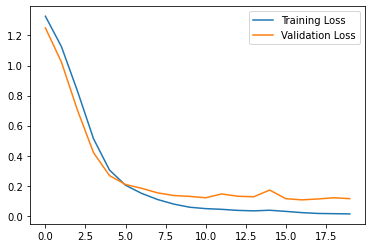

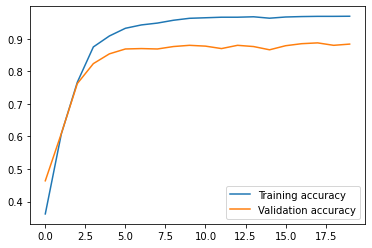

In [39]:
import matplotlib.pyplot as plt


plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(acc_history,label='Training accuracy')  
plt.plot(val_acc_history,label='Validation accuracy')  
plt.legend()  
plt.show()  

In [41]:
PATH = '/content/drive/MyDrive/dense121_weights(CNN-BiLSTM).pth'
torch.save(model, PATH)

# CM

In [42]:
dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

torch.Size([100, 3, 224, 224]) torch.Size([100])


In [43]:
images = images.view(images.shape[0], 1,images.shape[1], images.shape[2], images.shape[3])
images.shape

torch.Size([100, 1, 3, 224, 224])

In [44]:
output = model(images.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())

1


In [45]:
y_test = label.tolist()
y_pred = pred.tolist()

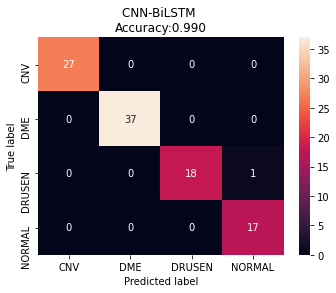

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd


# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = CATEGORIES, 
                     columns = CATEGORIES)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('CNN-BiLSTM \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('foo.png')
plt.show()

# Test

In [64]:
import cv2

# compose allow us to chain multiple transform together
transform1 = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

CATEGORIES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
        
path = '/content/16.png'
img = cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))  
print(img.shape)


img = transform1(img)
print(img.shape)
image = img.view(1, 1, img.shape[0], img.shape[1], img.shape[2])
print(image.shape)


output = model(image.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())
print(CATEGORIES[pred[0].item()])

(224, 224, 3)
torch.Size([3, 224, 224])
torch.Size([1, 1, 3, 224, 224])
1
DME
